# Mushashi and other RRMs

Here, we start from a couple of proteins from the 'RRM master alignment' to:
1. Find the connected uniprot code (via PDBe-KB)
2. Get UNIPROT information
3. Get ...


## 1. Read in the information from the Multiple Sequence Alignment (MSA)

Here, we read in the information from the file containing the sequence data

In [13]:
# Here we get a pre-defined function
from utils import extractFastaInfo, extractClustalInfo

msaFilePath = "rrm_short_msa.fasta"

# Extract the information
(seqAlignInfo,seqIds) = extractFastaInfo(msaFilePath)

# Print the information
print(seqIds)

['PDB:6NTY:A:1', 'PDB:4ZKA:A:1', 'PDB:5LSL:D:1', 'PDB:1H6K:Z:2', 'PDB:2ADB:A:2', 'PDB:1FJ7:A:1']


## 2. Get the associated UNIPROT codes

Here we collect the UNIPROT codes for the proteins for which we have the structures. The sequences
do not necessarily match, and the mapping between the PDB and UNIPROT is updated weekly.

In [14]:
import requests
import json

proteinIdToUniprot = {}
for currentProteinId in seqIds:
    currentPDBCode = currentProteinId[4:8].lower()
    currentPDBChain = currentProteinId[9:10]
    currentPDBEntity = currentProteinId[11:]

    post_url = "https://www.ebi.ac.uk/pdbe/graph-api/pdbe_pages/uniprot_mapping/{}/{}"

    response = requests.get(post_url.format(currentPDBCode,currentPDBEntity))
    responseJson = json.loads(response.text)

    if responseJson:
        print("Uniprot mapping collected for '{}'".format(currentPDBCode))
        proteinIdToUniprot[currentProteinId] = responseJson[currentPDBCode]['data'][0]['accession']
    else:
        print("No data for '{}'".format(currentPDBCode))

print(proteinIdToUniprot)

Uniprot mapping collected for '6nty'
Uniprot mapping collected for '4zka'
Uniprot mapping collected for '5lsl'
Uniprot mapping collected for '1h6k'
Uniprot mapping collected for '2adb'
Uniprot mapping collected for '1fj7'
{'PDB:6NTY:A:1': 'Q96DH6', 'PDB:4ZKA:A:1': 'Q9NWB1', 'PDB:5LSL:D:1': 'Q99181', 'PDB:1H6K:Z:2': 'P52298', 'PDB:2ADB:A:2': 'P26599', 'PDB:1FJ7:A:1': 'P08199'}


## 3. Download per-protein annotations from Uniprot

To download information from Uniprot, as we've seen you can get all information for an entry as XML or JSON file.
This is useful because it contains all available information for that protein.

However, if we are only interested in a couple of features for a big list of proteins, it would be a lot of extra
overhead to first download all the big files, and then pull out a small amount of data from them.
Therefore, Uniprot provided the **tab** format. This a plain text file where every column depicts one feature and
each row is an entry.

If you run into problems with 'ModuleNotFoundError', notably for 'pandas', you have to open your conda terminal (on Windows) or open a terminal window (on Mac/Linux), and type:

```conda install pandas```

That should install the code for you.

Play around with the `columns` in below code to see which information you can download, and what could be interesting to use.

The data is saved in a local file called `proteins.tab` - you can also change that file name to save into a different file.

In [15]:
from apiFunctions import uniprotDownload
import pandas as pd

# First collect the information on the uniprot IDs only
uniprotIds = list(proteinIdToUniprot.values())

# Here define the output file that will contain all the Uniprot information
# Note that you can change this name if you want to save data for different MSAs
# or if you change the data you want to get (in columns)
fileName="proteins.tab"

# You can find possible columns on this page https://www.uniprot.org/help/uniprotkb_column_names
columns="id,entry name,genes,organism,comment(PTM),3d,database(EMBL),database(GenBank),database(GeneID),lineage(all)"

query="id:"+"+OR+id:".join(uniprotIds)
format="tab"

# Download File from uniprot
uniprotDownload(fileName,query=query, format=format, columns=columns)

# Show with Pandas
proteinInfo = pd.read_csv(fileName, sep="\t").set_index("Entry").sort_index()
print(proteinInfo.index.values.tolist())
print(proteinInfo)

['P08199', 'P26599', 'P52298', 'Q96DH6', 'Q99181', 'Q9NWB1']
         Entry name                     Gene names  \
Entry                                                
P08199   NUCL_MESAU                            NCL   
P26599  PTBP1_HUMAN                      PTBP1 PTB   
P52298  NCBP2_HUMAN              NCBP2 CBP20 PIG55   
Q96DH6  MSI2H_HUMAN                           MSI2   
Q99181  HSH49_YEAST            HSH49 YOR319W O6142   
Q9NWB1  RFOX1_HUMAN  RBFOX1 A2BP A2BP1 FOX1 HRNBP1   

                                                 Organism  \
Entry                                                       
P08199              Mesocricetus auratus (Golden hamster)   
P26599                               Homo sapiens (Human)   
P52298                               Homo sapiens (Human)   
Q96DH6                               Homo sapiens (Human)   
Q99181  Saccharomyces cerevisiae (strain ATCC 204508 /...   
Q9NWB1                               Homo sapiens (Human)   

                 

## 4. Get STRING identifiers for protein-protein interaction information
[This database](https://string-db.org/) contains information about protein interactions.
Below you can find Python code to extract information via the STRING API; we are only
getting the STRING identifier, but this code can be extended to find all interaction
partners known by the STRING database.

In [18]:
## For a given list of proteins the script resolves them (if possible) to the best
## matching STRING identifier and prints out the mapping on screen in the TSV format

import sys

def getStringData(identifiers):
    string_api_url = "http://string-db.org/api"
    output_format = "tsv-no-header"
    method = "get_string_ids"

    ## construct params dictionary

    params = {

        "identifiers" : identifiers,
        "echo_query" : 1, # see your input identifiers in the output
        #"species" : 9606, # species NCBI identifier
        #"limit" : 1, # only one (best) identifier per input protein
        #"caller_identity" : "www.awesome_app.org" # your app name

    }

    ## contruct method URL

    request_url = string_api_url + "/" + output_format + "/" + method

    ## Call STRING

    try:
        response = requests.post(request_url, params=params)
    except requests.exceptions.RequestException as e:
        print(e)
        sys.exit()

    ## Read and parse the results

    c = 0
    with open('string_results.txt', 'w') as f:
        f.write(response.text.strip())
        for line in response.text.strip().split("\n"):
            l = line.split("\t")
            print(l)
            input_identifier, string_identifier = l[0], l[2]

            print("Input:", input_identifier, "STRING:", string_identifier, sep="\t")

stringIdentifiers = "\r".join(uniprotIds), # The list of proteins
getStringData(stringIdentifiers)


['Q96DH6', '0', '9606.ENSP00000284073', '9606', 'Homo sapiens', 'MSI2', 'RNA-binding protein Musashi homolog 2; RNA binding protein that regulates the expression of target mRNAs at the translation level. May play a role in the proliferation and maintenance of stem cells in the central nervous system (By similarity); Belongs to the Musashi family']
Input:	Q96DH6	STRING:	9606.ENSP00000284073
['Q9NWB1', '1', '9606.ENSP00000309117', '9606', 'Homo sapiens', 'RBFOX1', "RNA binding protein fox-1 homolog 1; RNA-binding protein that regulates alternative splicing events by binding to 5'-UGCAUGU-3' elements. Regulates alternative splicing of tissue-specific exons and of differentially spliced exons during erythropoiesis"]
Input:	Q9NWB1	STRING:	9606.ENSP00000309117
['P52298', '3', '9606.ENSP00000326806', '9606', 'Homo sapiens', 'NCBP2', "Nuclear cap-binding protein subunit 2; Component of the cap-binding complex (CBC), which binds co-transcriptionally to the 5' cap of pre-mRNAs and is involved in

## 5. Get information on short linear motifs from ELM
Below is a simple Python code to extract information via the ELM API.

In [ ]:
sequence= 'MAAGGSGAESAPPTPSMSSLPLAALNVRVRHRLSLFLNVRTQVAADWTGLAEEM\
NFEYLEIRRLETHPDPTRSLLDDWQGRPGASVGRLLELLAKLGRDDVLVELGPS\
IEEDCRKYILKQQQEAAEKPLQVDSVDSSIPWMSGITIRDDPLGQMPEHFDAFI\
CYCPSDIQFVQEMIRQLEQTNYRLKLCVSDRDVLPGTCVWSIASELIEKRCRRM\
VVVVSDDYLQSKECDFQTKFALSLSPGAHQKRLIPVKYKSMKKEFPSILRFITV\
CDYTNPCTKSWFWTRLARALSLP'

# defining the api-endpoint
api_endpoint = "http://elm.eu.org/start_search/"

#Submiting a protein identifier
def elm_id_submit(uniprotId):
    uniprot_id = uniprotId + '.tsv'
    url = api_endpoint + uniprot_id
    response = requests.get(url)
    # Output file
    with open('ELM_result1.txt', 'w') as f:
        f.write(response.content.decode("utf-8"))
        print(response.content.decode("utf-8"))
    return(response.content)

#Submitting a single sequence
def elm_seq_submit(sequence):
    url = api_endpoint + sequence
    response = requests.get(url)
    # Output file
    with open('ELM_result2.txt', 'w') as f:
        f.write(response.content.decode("utf-8"))
        print(response.content.decode("utf-8"))
    return response.content

# Can search both by uniprot identifier or by a (novel) sequence
elm_id_submit(uniprotIds[0]) #
elm_seq_submit(sequence)


## 6. Secondary structure information from the PDBe REST API

Back to the secondary structure, we will re-create the information we made earlier.

In [24]:
import json

def getSecondaryStructureData(pdbCodes):
    # API Post URL
    # Secondary structure info
    post_url = "https://www.ebi.ac.uk/pdbe/api/pdb/entry/secondary_structure/{}"
    
    responseDict = {}

    # Make POST request
    # WV 190206 - ADDED the 'data =' in below for it to work on Python dictionary
    for pdbCode in pdbCodes:
        response = requests.get(post_url.format(pdbCode))
        responseJson = json.loads(response.text)
        
        if responseJson:
            print("Data collected for '{}'".format(pdbCode))
            responseDict.update(responseJson)
        else:
            print("No data for '{}'".format(pdbCode))
    
    return responseDict


# The input should contain one or more comma-separated PDB ids, which we make here with
# some Python magic
pdbCodes = [seqId[4:8].lower() for seqId in seqIds]

# Get the secondary structure information, and print it
results1 = getSecondaryStructureData(pdbCodes)
print(results1)

# We are saving the data in a JSON file for later use, so we don't have to get the data again if we turn
# off the computer
json1 = json.dumps(results1)

secondaryStructureJsonFile = "SecondaryStructure.json"
f = open(secondaryStructureJsonFile, "w")
f.write(json1)
f.close()


Data collected for '6nty'
Data collected for '4zka'
Data collected for '5lsl'
Data collected for '1h6k'
Data collected for '2adb'
Data collected for '1fj7'
{'6nty': {'molecules': [{'entity_id': 1, 'chains': [{'chain_id': 'A', 'struct_asym_id': 'A', 'secondary_structure': {'helices': [{'start': {'author_residue_number': 33, 'author_insertion_code': None, 'residue_number': 16}, 'end': {'author_residue_number': 42, 'author_insertion_code': None, 'residue_number': 25}}, {'start': {'author_residue_number': 43, 'author_insertion_code': None, 'residue_number': 26}, 'end': {'author_residue_number': 45, 'author_insertion_code': None, 'residue_number': 28}}, {'start': {'author_residue_number': 72, 'author_insertion_code': None, 'residue_number': 55}, 'end': {'author_residue_number': 80, 'author_insertion_code': None, 'residue_number': 63}}], 'strands': [{'start': {'author_residue_number': 22, 'author_insertion_code': None, 'residue_number': 5}, 'sheet_id': 1, 'end': {'author_residue_number': 28,

### 7. Get the biophysical predictions

Again redoing this part.

In [25]:
import requests
import time

WAIT_TIME = 5
TOTAL_TIME = 3000

## input parameters ##
url = 'https://bio2byte.be/msatools/'
apiUrl = url + 'api/'

def getDataForMsa(inputFile,outputFile):

    # Read input MSA file
    file = open(inputFile, 'r')
    inputData = file.read()

    request_json = {"token": "J1H5G3F2D2",
                    "tool": 'msatoolsproteins',
                    'file_content': inputData}

    print(request_json)
    print("Posting data to server...")
    # Make POST request with Json Input body
    r = requests.post(url = apiUrl, data=request_json)
    get_address = json.loads(r.content.decode("utf-8"))["Location"]
    resultUrl = url + get_address

    print("Fetching results...")

    # Now get results - or fail when time limit reached
    time_waited = 0
    while time_waited / TOTAL_TIME < 1.0:

      # Get Request
      response = requests.get(resultUrl)

      if response.status_code == 202:
        print("  Waiting for results...")

      elif response.status_code == 200:
        queryResults = json.loads(response.text)
        break

      else:
        print("Server error, response {}.".format(response.status_code))
        break

      time.sleep(WAIT_TIME)
      time_waited += WAIT_TIME

    # save the results to a json file
    predJsonData = json.dumps(queryResults)
    f = open(outputFile, "w")
    f.write(predJsonData)
    f.close()

    return queryResults


# This is the file where the predictions are saved - can change the name if you re-run this
# for another set of protein!
predJsonFile = 'predictions.json'

results = getDataForMsa(msaFilePath,predJsonFile)

print(results)

{'token': 'J1H5G3F2D2', 'tool': 'msatoolsproteins', 'file_content': '>PDB:6NTY:A:1 Mushashi\n---------------NAGKMFIGGLSWQTSPDSLRDYFSKFGEIRECMVMRDPTTKRSRGFGFVTFADPASVDKVLGQPHHE---LDSKTIDPKVAFPRR------------------------------------\n>PDB:4ZKA:A:1 AMPC_ECOLI\n-----------ENKSQPKRLHVSNIPFRFRDPDLRQMFGQFGKILDVEIIFNER--GSKGFGFVTFENSADADRAREKLHGT--VVEGRKIEVNNATA--------------------------------------\n>PDB:5LSL:D:1 HSH49_YEAST\n----------------GNTVYVGNIDPRITKEQLYELFIQINPVLRIKYPKDKVLQAYQGYAFIEFYNQGDAQYAIKIMNNTV-RLYDRLIKVR--QV--------------------------------------\n>PDB:1H6K:Z:2  NCBP2_HUMAN\n---------------KSCTLYVGNLSFYTTEEQIYELFSKSGDIKKIIMGLDKM---KCGFCFVEYYSRADAENAMRYINGT--RLDDRIIRTDW-DAG-------------------------------------\n>PDB:2ADB:A:2  PTBP1_HUMAN\n-----DAGMAMAGQSPVLRIIVENLFYPVTLDVLHQIFSKFGTVLKIITFTKN----NQFQALLQYADPVSAQHAKLSLDGQNIYNACCTLRIDFSKLTSLNVKYNNDKSRDYTRPDLPSGDSQPSLDQTMAAAFG\n>PDB:1FJ7:A:1  NUCL_MESAU\nGSHMLEDPVEGSESTTPFNLFIGNLNPNKSVAELKVAISELFAKNDLAVVDVRTG-TNRKFGYVDFESAEDLEKA-LELTG

### 8. Integrate and analyse
We can then also analyse the results. Below is a simple example to compare the predictions for the
alpha-helices to the beta-strands, but this could be refined to for example compare the
characteristics between the different beta-strands found in RRMs.

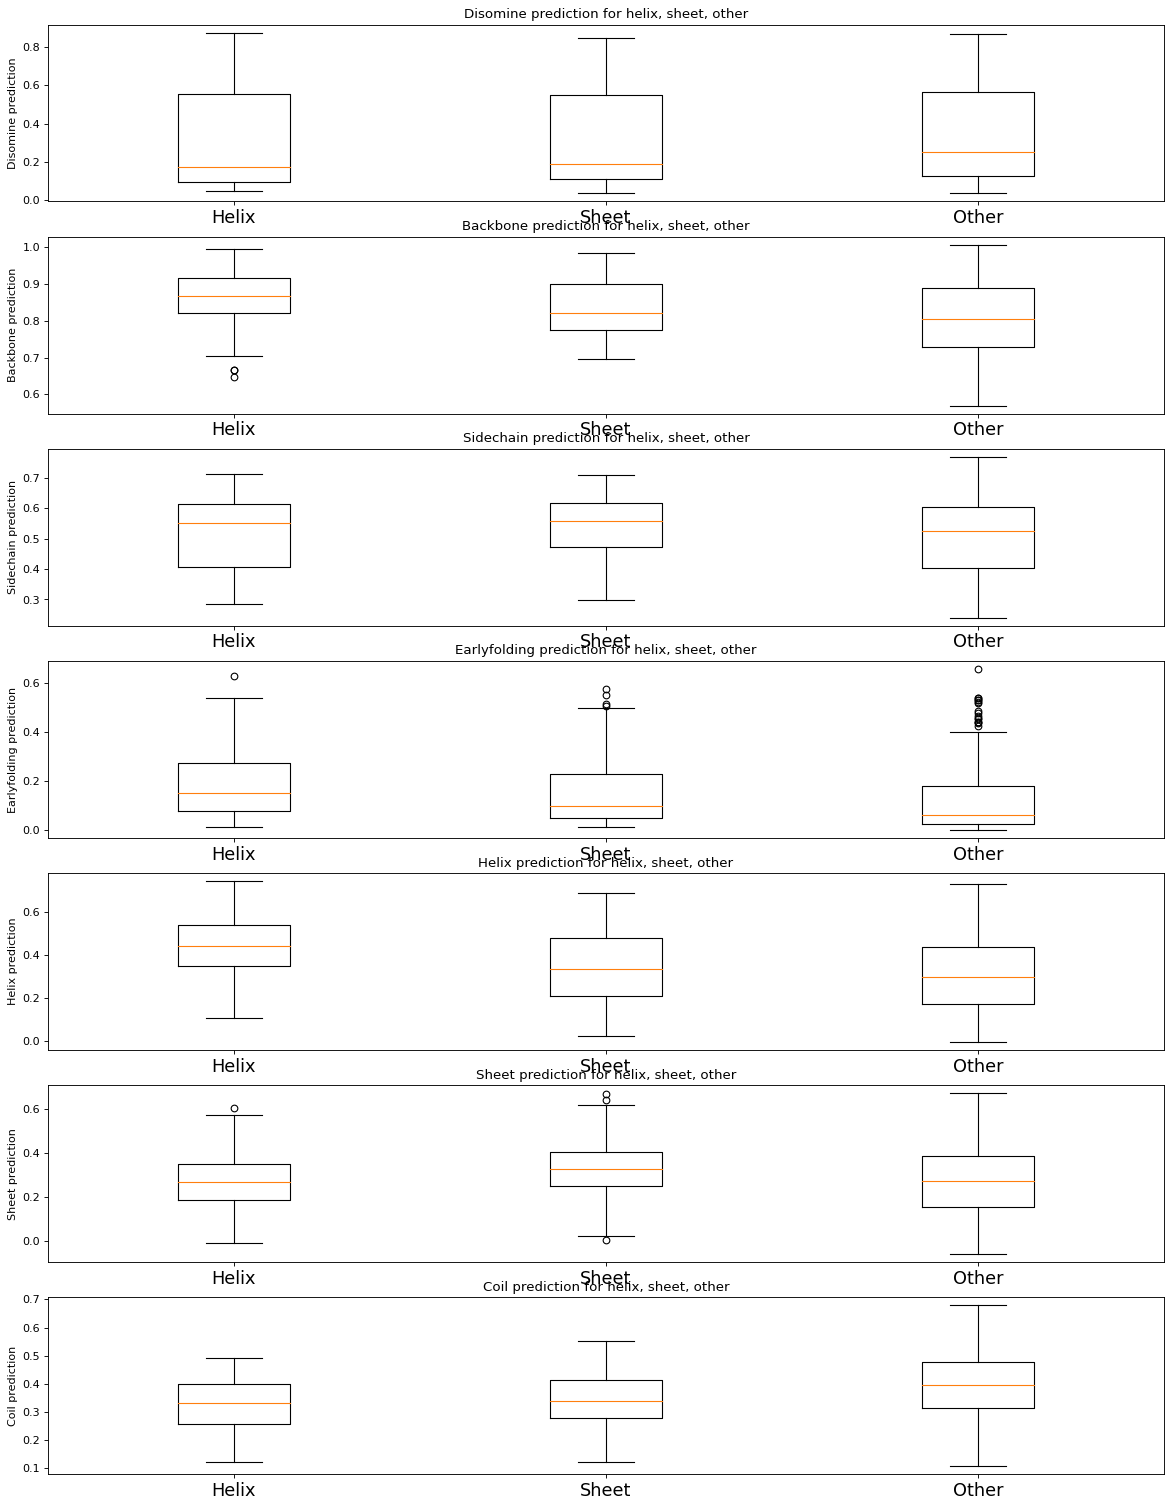

In [32]:
import matplotlib.pyplot as plt
import json

# Read Json file with secondary structures
file = open(secondaryStructureJsonFile, 'r')
ss_json = json.loads(file.read())

# Read Json file with predictions
file = open(predJsonFile, 'r')
request_json = json.loads(file.read())

# Instead of showing the predictions for one protein, we will now collect
# information over all proteins, to get the prediction values associated
# with helix, sheet and 'other' secondary structure. We can then statistically
# compare these to each other.

dataValues = {'helix': {}, 'sheet': {}, 'other': {}} # This is the actual secondary structure
predictionTypes = ['disoMine', 'backbone', 'sidechain', 'earlyFolding', 'helix', 'sheet', 'coil'] # These are the prediction names
for predictionType in predictionTypes:
    dataValues['helix'][predictionType] = []
    dataValues['sheet'][predictionType] = []
    dataValues['other'][predictionType] = []

for proteinInfo in request_json["results"]:
    currentProteinId = proteinInfo['proteinID']
    currentPDBCode = currentProteinId[4:8].lower()
    currentPDBChain = currentProteinId[9:10]
    sequence = proteinInfo['sequence']

    #Secondary structure
    helixSeqCodes = []
    sheetSeqCodes = []

    currentInfo = ss_json[currentPDBCode]
    for moleculeInfo in currentInfo['molecules']:
        for chainInfo in moleculeInfo['chains']:
            if chainInfo['chain_id'] == currentPDBChain:
                secStrucInfo = chainInfo['secondary_structure']

                for helixInfo in secStrucInfo['helices']:
                    helixSeqCodes.extend(range(int(helixInfo['start']['residue_number']),int(helixInfo['end']['residue_number'])+1))
                for strandInfo in secStrucInfo['strands']:
                    sheetSeqCodes.extend(range(int(strandInfo['start']['residue_number']),int(strandInfo['end']['residue_number'])+1))

    # Now collect the values
    for predictionType in predictionTypes:
        currentValues =  [value for value in proteinInfo[predictionType] if value != None]
        for seqIndex in range(len(sequence)):
            seqCode = seqIndex + 1
            currentValue = currentValues[seqIndex]
            if seqCode in helixSeqCodes:
                ssType = 'helix'
            elif seqCode in sheetSeqCodes:
                ssType = 'sheet'
            else:
                ssType = 'other'

            dataValues[ssType][predictionType].append(currentValue)


# creating a plot
fig = plt.figure(figsize=(18, 24), dpi= 80, facecolor='w', edgecolor='k')

# Plotting the distribution of predictions values for helices, sheets, other
plotCode = 711
for predictionType in predictionTypes:
    axes = fig.add_subplot(plotCode)
    axes.boxplot([dataValues['helix'][predictionType],dataValues['sheet'][predictionType],dataValues['other'][predictionType]])
    axes.set_title("{} prediction for helix, sheet, other".format(predictionType.capitalize()))
    axes.set_ylabel("{} prediction".format(predictionType.capitalize()))
    # Here we label the boxplots on the x-axis
    axes.set_xticklabels(['Helix','Sheet','Other'],fontsize=16)
    plotCode += 1

plt.show()



